# Transfer Learning

https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

<설치></br>
conda install keras

In [1]:
# __future__ :파이썬 2 버전과 파이썬 3 버전의 호환을 위하여 사용되는 모듈
from __future__ import absolute_import, division, print_function 

# OS: 운영체제와 관련된 명령을 수행할 수 있다.
import os
# opencv2 의 모듈을 사용할 수 있다.
import cv2

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

# pyplot: 그래프를 그리기위해 지원되는 모듈 
import matplotlib.pyplot as plt

# image: matplotlib에서 이미지를 활용하고자 할 때 사용하는 모듈
import matplotlib.image as mpimg


TensorFlow version is  2.2.0


In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


### Data preprocessing

In [0]:
# 데이터 가져오기

base_dir= "/gdrive/My Drive/MAFA"

In [0]:
pwd

'/content'

In [0]:
# train폴더와 test폴더 경로명 생성 및 저장
train_dir = os.path.join(base_dir, 'train_images')
test_dir = os.path.join(base_dir, 'test_images')

In [7]:

# train masked 이미지가 들어있는 경로
train_masked_dir = os.path.join(train_dir, 'MASKED_train')
print ('Total training masked images:', len(os.listdir(train_masked_dir)))

# train naked 이미지가 들어있는 경로명 생성 및 저장
train_naked_dir = os.path.join(train_dir, 'NAKED_train')
print ('Total training naked images:', len(os.listdir(train_naked_dir)))

# validaton masked 이미지가 들어있는 경로명 생성 및 저장
validation_masked_dir = os.path.join(test_dir, 'MASKED_test')
print ('Total validation masked images:', len(os.listdir(validation_masked_dir)))

# validaton naked 이미지가 들어있는 경로명 생성 및 저장
validation_naked_dir = os.path.join(test_dir, 'NAKED_test')
print ('Total validation naked images:', len(os.listdir(validation_naked_dir)))

Total training masked images: 21646
Total training naked images: 4233
Total validation masked images: 3881
Total validation naked images: 1054


### Create Image Data Generator with Image Augmentation

- ImageDataGenerator() 참고: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

In [8]:
image_size = 224 # All images will be resized to 224 x 224
batch_size = 64

# Rescale
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 디렉토리에서 바로 레이블과 이미지 가져오기 
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
                test_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

#클래스 인덱스 정보 보기 
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 26131 images belonging to 3 classes.
Found 4935 images belonging to 2 classes.
{'MASKED_train': 0, 'NAKED_cropped_train': 1, 'NAKED_train': 2}
{'MASKED_test': 0, 'NAKED_test': 1}


- class_mode : 분류 방식에 대해서 지정합니다. 다중 클래스일 경우 "categorical"로 지정해주세요
  

### Create the base model from the pre-trained convnets

- tensorflow.keras.applications 모듈을 사용하여 pretrained된 모델을 사용할 수 있다.
- Xception, VGG16, VGG19, ResNet, InseptionV3, InseptionResNetV2, MobileNet, DenseNet, NASNet 사용가능 

- 참고사이트: https://keras.io/applications/

In [9]:
IMG_SHAPE = (image_size, image_size, 3)

#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.NASNetLarge(input_shape=None,
                                               include_top=False, 
                                               weights='imagenet',
                                               input_tensor=None,
                                               pooling=None,
                                               classes=2,)

343613440/343610240 [==============================] - 6s 0us/step


## Feature extraction

### Freeze the convolutional base  

In [0]:
#분류기를 제외하고 가져온 모델부분을  Freeze 시켜 학습시에도 가중치가 변하지 않도록 함
base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

##### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='relu')
])

- 다중 분류의 경우 activation = "softmax"

### Compile the model

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

- loss의 경우 다중 클래스 분류일 때 "categorical_crossentropy"를 설정해주면 된다.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4033      
Total params: 84,920,851
Trainable params: 4,033
Non-trainable params: 84,916,818
_________________________________________________________________


## Train

- "could not import PIL.Image" 오류발생시
- 참고: https://stackoverflow.com/questions/48225729/importerrorcould-not-import-pil-image-working-with-keras-ternsorflow/50775336

- pip install Pillow 를 통해 해당 가상환경에 Pillow를 설치해주면 됩니다.

In [0]:
epochs = 8
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

### Learning curves

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Fine tuning

In [0]:
base_model.trainable = True

In [13]:
# base model의 layer 갯수를 확인
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  1039


In [0]:
# Fine tuning을 시킬 기준 layer 선정
fine_tune_at = 980

# Fine tuning을 시킬 기준 layer 이전의 layer들을 모두 freezing
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

### Compile the model

In [0]:
lr=0.0001
#lr=0.00002

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4033      
Total params: 84,920,851
Trainable params: 10,063,873
Non-trainable params: 74,856,978
_________________________________________________________________


In [22]:
len(model.trainable_variables)

56

In [23]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [24]:
model.trainable_variables

[<tf.Variable 'separable_conv_2_bn_normal_right1_17/gamma:0' shape=(672,) dtype=float32, numpy=
 array([0.9330666 , 0.8811506 , 0.9075716 , 0.8550798 , 0.86076427,
        0.9611022 , 0.7659452 , 0.7469428 , 0.79562354, 0.85615075,
        0.8689585 , 0.88267094, 0.7535871 , 0.72406554, 0.7576023 ,
        0.8400042 , 0.85588986, 0.8445289 , 0.93673944, 0.90556556,
        0.3953283 , 0.90957874, 0.85925066, 0.55353475, 0.9328826 ,
        0.8690639 , 0.85045344, 0.46634918, 0.91864556, 0.83142906,
        0.8671327 , 0.829499  , 0.7427956 , 0.89597434, 0.57549167,
        0.26472375, 0.73758686, 0.8919982 , 0.67340803, 0.35408035,
        0.8866026 , 0.8019172 , 0.86335635, 0.88363034, 0.9394955 ,
        0.35809106, 0.9025929 , 0.7607741 , 0.86436397, 0.65215117,
        0.8254749 , 0.8669643 , 0.6758967 , 0.83101636, 0.8478835 ,
        0.64955384, 0.7523726 , 0.7017902 , 0.9250206 , 0.7953102 ,
        0.7924673 , 0.8571368 , 0.906655  , 0.34937847, 0.9814636 ,
        0.84408355, 

### Continue Train the model

In [25]:
epochs = 8
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
 16/408 [>.............................] - ETA: 38:00 - loss: 1.3118 - accuracy: 0.6748

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


408/408 [==============================] - 3963s 10s/step - loss: 1.3288 - accuracy: 0.7083 - val_loss: 3.2897 - val_accuracy: 0.7867
Epoch 2/8
408/408 [==============================] - 399s 977ms/step - loss: 0.8848 - accuracy: 0.7623 - val_loss: 3.2960 - val_accuracy: 0.7863
Epoch 3/8
408/408 [==============================] - 398s 976ms/step - loss: 0.7587 - accuracy: 0.7672 - val_loss: 11.5062 - val_accuracy: 0.2455
Epoch 4/8
408/408 [==============================] - 398s 975ms/step - loss: 0.9063 - accuracy: 0.7682 - val_loss: 7.3095 - val_accuracy: 0.5142
Epoch 5/8
408/408 [==============================] - 398s 976ms/step - loss: 0.6945 - accuracy: 0.7744 - val_loss: 5.8822 - val_accuracy: 0.6118
Epoch 6/8
408/408 [==============================] - 397s 973ms/step - loss: 1.0464 - accuracy: 0.7724 - val_loss: 3.4681 - val_accuracy: 0.7727
Epoch 7/8
408/408 [==============================] - 398s 974ms/step - loss: 1.1511 - accuracy: 0.7092 - val_loss: 3.5501 - val_accuracy: 0.

### Learning curves 

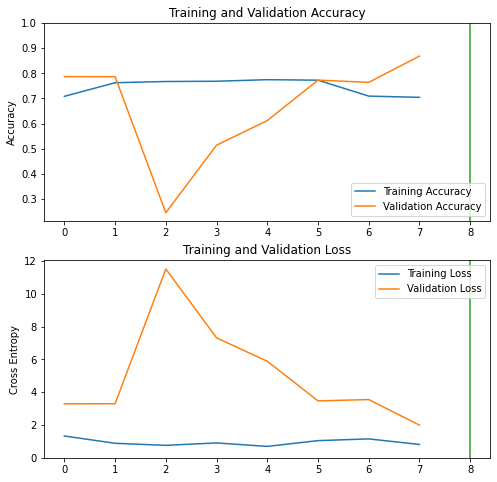

In [26]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
import time
start = time.time()
print("time :", start)

pred = model.predict_classes(
    validation_generator
)

print("time : ", time.time() - start)

time : 1591037402.7112834
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
time :  64.43232226371765
